In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

# model = Net().to(DEVICE)
# inp = torch.rand(1, 1, 28, 28).to(DEVICE)
# print(model(inp).shape)

In [3]:
class Net_v2(nn.Module):
    def __init__(self):
        super(Net_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        # STEM
        x = self.conv1(x)
        #print(x.shape)
        x = self.bnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bnorm2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bnorm3(x)
        x = F.relu(x)

        x = self.drop(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

model = Net_v2().to(DEVICE)
inp = torch.rand(1, 1, 28, 28).to(DEVICE)
print(model(inp).shape)

torch.Size([1, 10])


In [2]:
train_transforms = transforms.Compose([
    # Add random transformations to the image.
    transforms.RandomAffine(
        degrees=30, translate=(0.5, 0.5), scale=(0.25, 1),
        shear=(-30, 30, -30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=train_transforms)
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                       transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256)

In [6]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [9]:
import copy
import os, io
import pickle
from typing import Optional
from tqdm.notebook import tqdm

# https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: 
            return super().find_class(module, name)

def train_fn(model: nn.Module,
             data: torch.utils.data.DataLoader,
             epoch: int,
             loss_fn: torch.nn.modules.loss,
             optimizer: torch.optim.Optimizer,
             scheduler: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
             savepath: str = None,
             device='cpu'):

    best_weight = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0

    if savepath and os.path.exists(savepath):
        # Try loading the model and weight
        try:
            with open(savepath, 'rb') as filehandler:
                prev_train = CPU_Unpickler(filehandler).load()
                best_weight = prev_train['best_weight']
                model.load_state_dict(best_weight)
                best_loss = prev_train['best_loss']
                print(f"Loaded model with loss: {best_loss:0.4f}")
        except:
            print(f"Could not load from path: {savepath}")

    # Gathering all dataset phases
    train_phases = list(data.keys())
    dataset_sizes = {train_phase : len(data[train_phase].dataset) \
                     for train_phase in train_phases}

    for e in range(epoch):
        for phase in train_phases:
            is_training = (phase == 'train')
            model.train() if is_training else model.eval()

            loss, corrects, dats = 0., 0., 0.
            tqdm_data = tqdm(data[phase])

            for x, y in tqdm_data:
                x, y = x.to(device), y.to(device)

                # Clearing optimizer
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(x)
                    max_logits, classes = torch.max(pred, 1)
                    batch_loss = loss_fn(pred, y)

                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()

                # Stats
                dats += x.size(0)
                loss += batch_loss.item() * x.size(0)
                corrects += torch.sum(classes == y.data)
                tqdm_data.set_description(f"Epoch {e+1} [{phase.capitalize()}]:: Loss: {loss/dats:.4f}, AC: {corrects/dats:.4f}")

            epoch_loss = loss / dataset_sizes[phase]
            epoch_acc = corrects.double() / dataset_sizes[phase]

            if scheduler and is_training: scheduler.step()

            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weight = copy.deepcopy(model.state_dict())
                if savepath:
                    with open(savepath, 'wb') as filehandler:
                        pickle.dump({
                            'best_weight': best_weight,
                            'best_loss': epoch_loss,
                            'best_acc': best_acc,
                        }, filehandler)
                print(f"Best acc found: {best_acc:3.4f}")

    print(f'Best accuracy: {best_acc:3.4f}')
    model.load_state_dict(best_weight)

In [ ]:
train_fn(
    model = model,
    data = {
        "test": test_loader,
        "train": train_loader,
    },
    epoch = 50,
    loss_fn = F.cross_entropy,
    optimizer = optimizer,
    #scheduler = scheduler,
    savepath = "mnist_v2.pkl",
    device = DEVICE
)

torch.Size([256, 1, 28, 28]) 8 32


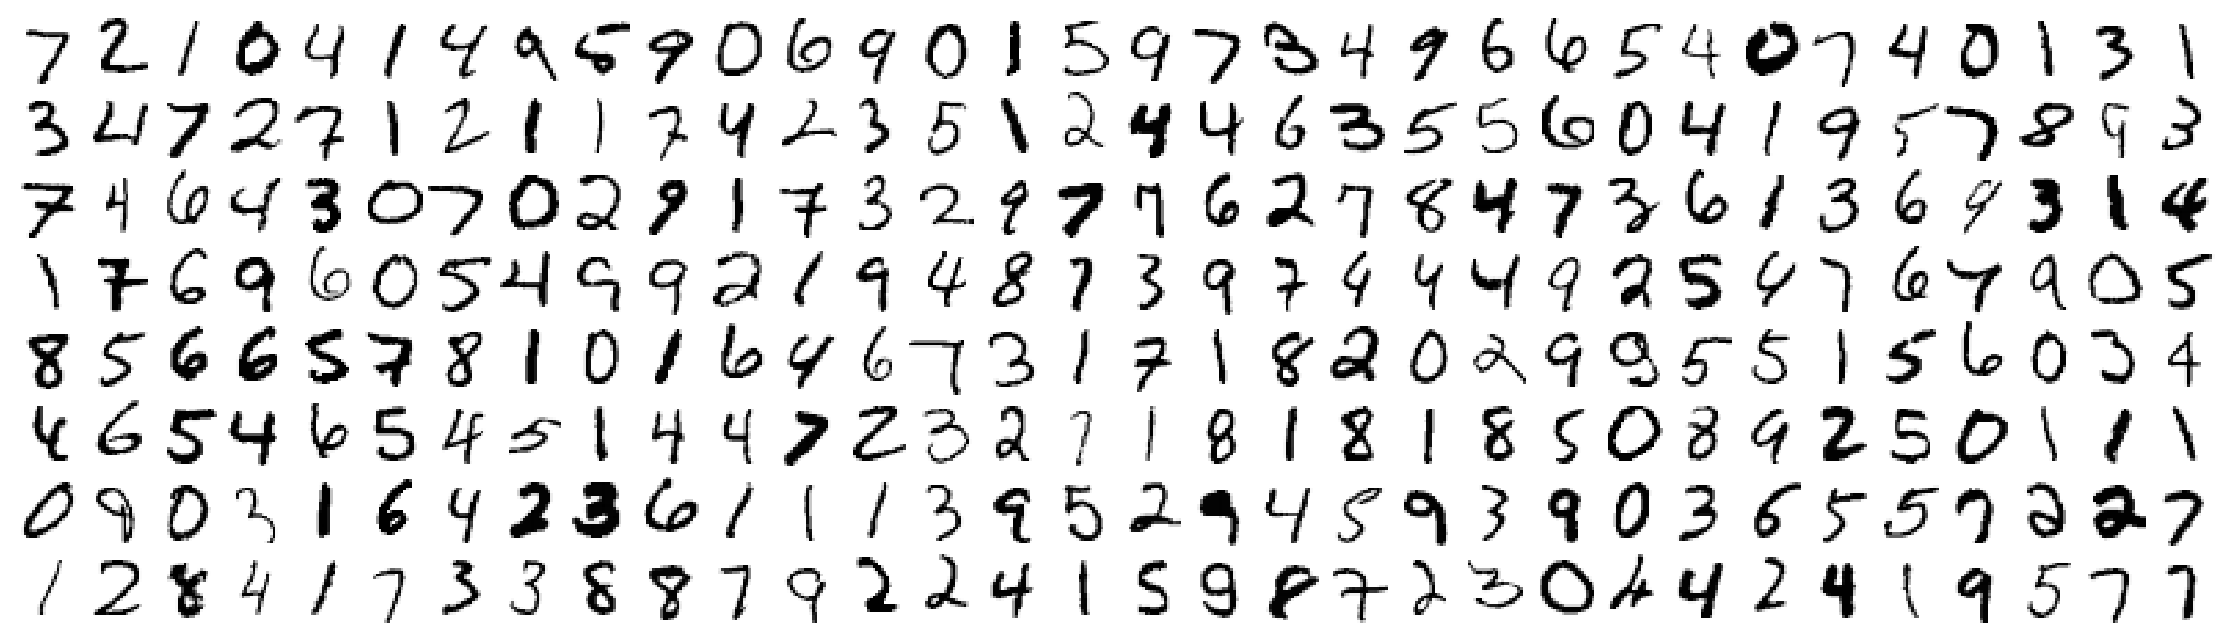

In [8]:
import matplotlib.pyplot as plt

def plot_grid(batch_image):
    n_plots = batch_image.shape[0]
    rows = 8
    cols = n_plots // rows
    plt.figure(figsize=(cols, rows))
    print(batch_image.shape, rows, cols)

    for i, img in enumerate(batch_image):
        # img = 255 - img
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="Greys",
                   interpolation="nearest")
        plt.axis('off')

    plt.subplots_adjust(wspace=-.8, hspace=0)
    plt.show()

for x, y in test_loader:
    a = x
    break

plot_grid(a)